In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from common import get_all_data

player_data, rank_match_data, rank_player_match_data, swift_match_data, swift_player_match_data = get_all_data()

print(rank_player_match_data.columns)
print(player_data.columns)
print(rank_match_data.columns)
print(swift_match_data.columns)
print(swift_player_match_data.columns)

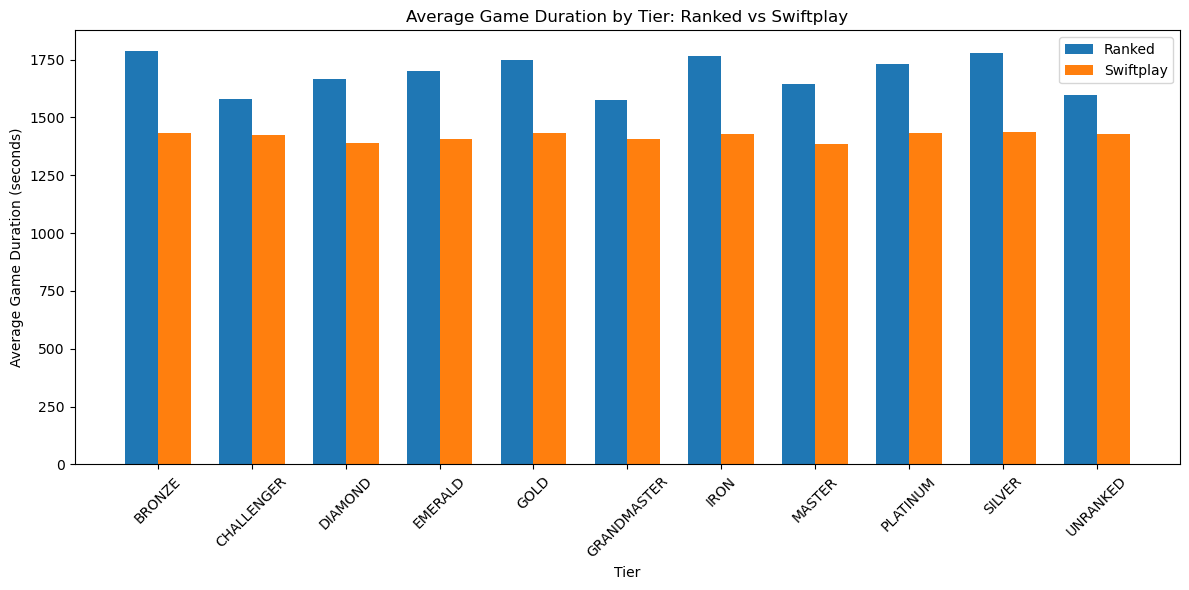

In [14]:
# Swiftplay duration vs Ranked duration

# Merge Ranked datasets
ranked_merged = pd.merge(rank_player_match_data, rank_match_data, on="matchId")
ranked_duration = ranked_merged.groupby("tier")["gameDuration"].mean().reset_index()
ranked_duration = ranked_duration.sort_values("tier")

# Merge Swiftplay datasets
swift_merged = pd.merge(swift_player_match_data, swift_match_data, on="matchId")
swift_duration = swift_merged.groupby("tier")["gameDuration"].mean().reset_index()
swift_duration = swift_duration.sort_values("tier")

# Merge both on tier
combined = pd.merge(ranked_duration, swift_duration, on="tier", suffixes=("_Ranked", "_Swift"))

# Plotting side-by-side bar chart
x = np.arange(len(combined["tier"]))  # label locations
width = 0.35  # width of the bars

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, combined["gameDuration_Ranked"], width, label="Ranked")
plt.bar(x + width/2, combined["gameDuration_Swift"], width, label="Swiftplay")

plt.xlabel("Tier")
plt.ylabel("Average Game Duration (seconds)")
plt.title("Average Game Duration by Tier: Ranked vs Swiftplay")
plt.xticks(x, combined["tier"], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Ranked - Early Surrender: 2.26%
Ranked - Regular Surrender: 26.23%
Swiftplay - Early Surrender: 3.70%
Swiftplay - Regular Surrender: 39.67%


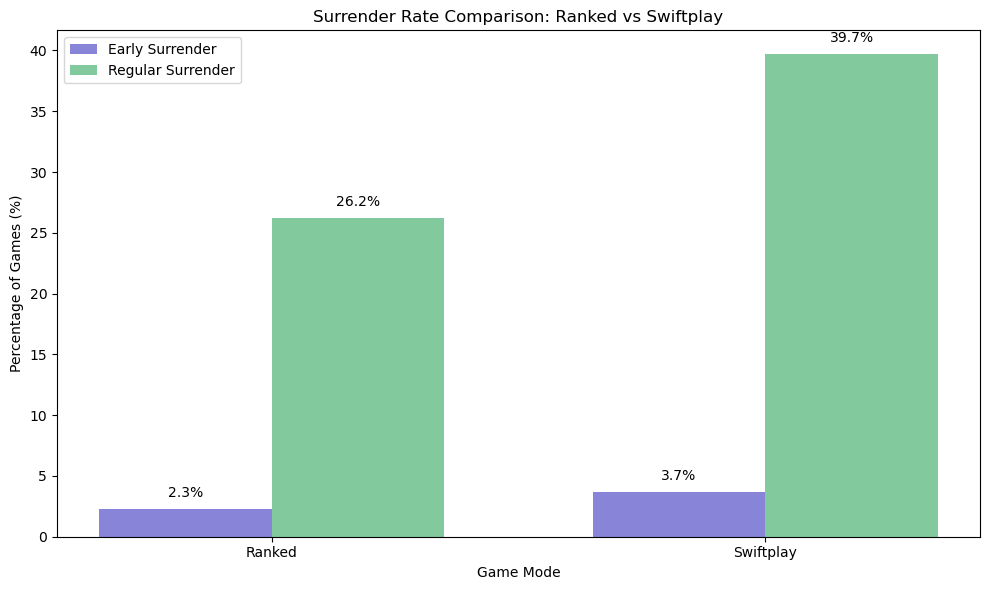

In [15]:
def get_surrender_percentage(groupby_obj):
    # count the occurrences of each boolean value
    counts = groupby_obj.size()
    
    # if true isn't in the index, that means there are no surrenders
    if True not in counts.index:
        return 0
    
    # calculate percentage of true values
    total = counts.sum()
    true_count = counts.get(True, 0)
    percentage = (true_count / total) * 100
    
    return percentage

# In all games, the percentage of gameEnded InEarlySurrender, and gameEndedInSurrender
# compare rate of games ended in early surrender and games ended in surrender in ranked with 
# games ended in early surrender and games ended in surrender in swiftplay

swiftplay_early_surrender = swift_match_data.groupby("gameEndedInEarlySurrender")
swiftplay_surrender = swift_match_data.groupby("gameEndedInSurrender")
ranked_early_surrender = rank_match_data.groupby("gameEndedInEarlySurrender")
ranked_surrender = rank_match_data.groupby("gameEndedInSurrender")

swiftplay_early_pct = get_surrender_percentage(swiftplay_early_surrender)
swiftplay_regular_pct = get_surrender_percentage(swiftplay_surrender)
ranked_early_pct = get_surrender_percentage(ranked_early_surrender)
ranked_regular_pct = get_surrender_percentage(ranked_surrender)

# print the calculated percentages
print(f"Ranked - Early Surrender: {ranked_early_pct:.2f}%")
print(f"Ranked - Regular Surrender: {ranked_regular_pct:.2f}%")
print(f"Swiftplay - Early Surrender: {swiftplay_early_pct:.2f}%")
print(f"Swiftplay - Regular Surrender: {swiftplay_regular_pct:.2f}%")

# create a df for plotting
data = {
    'Game Mode': ['Ranked', 'Ranked', 'Swiftplay', 'Swiftplay'],
    'Surrender Type': ['Early Surrender', 'Regular Surrender', 'Early Surrender', 'Regular Surrender'],
    'Percentage': [ranked_early_pct, ranked_regular_pct, swiftplay_early_pct, swiftplay_regular_pct]
}
plot_df = pd.DataFrame(data)

# create grouped bar chart
plt.figure(figsize=(10, 6))

# prepare data for grouped bar chart
x = np.array([0, 1])  # positions for ranked and swiftplay
width = 0.35

# create bars
plt.bar(x - width/2, [ranked_early_pct, swiftplay_early_pct], width, 
        label='Early Surrender', color='#8884d8')
plt.bar(x + width/2, [ranked_regular_pct, swiftplay_regular_pct], width,
        label='Regular Surrender', color='#82ca9d')

# add labels and title
plt.xlabel('Game Mode')
plt.ylabel('Percentage of Games (%)')
plt.title('Surrender Rate Comparison: Ranked vs Swiftplay')
plt.xticks(x, ['Ranked', 'Swiftplay'])
plt.legend()

# add percentage values on top of bars
plt.text(x[0] - width/2, ranked_early_pct + 1, f'{ranked_early_pct:.1f}%', ha='center')
plt.text(x[0] + width/2, ranked_regular_pct + 1, f'{ranked_regular_pct:.1f}%', ha='center')
plt.text(x[1] - width/2, swiftplay_early_pct + 1, f'{swiftplay_early_pct:.1f}%', ha='center')
plt.text(x[1] + width/2, swiftplay_regular_pct + 1, f'{swiftplay_regular_pct:.1f}%', ha='center')

plt.tight_layout()
# plt.savefig('surrender_comparison.png')
plt.show()



In [16]:
# Out of those who surrender, how are they divided by rank for both swiftplay and ranked?
# left join rankedplayermatchdata with rankedmatches by matchid, filter out games without surrender, merge with players by puuid, access how many of
# each tier exist in pie chart

# Merge Ranked datasets
ranked_merged = pd.merge(rank_player_match_data, rank_match_data, on="matchId")

# filter only surrendered games (either early or regular surrender)
ranked_surrendered = ranked_merged[(ranked_merged["gameEndedInEarlySurrender"] == True) | 
                                  (ranked_merged["gameEndedInSurrender"] == True)]

ranked_surrender_with_tier = pd.merge(ranked_surrendered, player_data, on="puuid")
# For Swiftplay games
swift_merged = pd.merge(swift_player_match_data, swift_match_data, on="matchId")

# Filter only surrendered games
swift_surrendered = swift_merged[(swift_merged["gameEndedInEarlySurrender"] == True) | 
                                (swift_merged["gameEndedInSurrender"] == True)]

# Merge with player data
swift_surrender_with_tier = pd.merge(swift_surrendered, player_data, on="puuid")

# Step 2: Count surrenders by tier for each game mode
ranked_tier_counts = ranked_surrender_with_tier["tier"].value_counts().reset_index()
ranked_tier_counts.columns = ["tier", "count"]

swift_tier_counts = swift_surrender_with_tier["tier"].value_counts().reset_index()
swift_tier_counts.columns = ["tier", "count"]

tier_order = ["IRON", "BRONZE", "SILVER", "GOLD", "PLATINUM", "DIAMOND", "MASTER", "GRANDMASTER", "CHALLENGER"]

# Filter to only include tiers that exist in our data
ranked_tier_order = [tier for tier in tier_order if tier in ranked_tier_counts["tier"].values]
swift_tier_order = [tier for tier in tier_order if tier in swift_tier_counts["tier"].values]

#Sort the DataFrames based on the tier order
ranked_tier_counts["tier_order"] = ranked_tier_counts["tier"].apply(lambda x: tier_order.index(x) if x in tier_order else 999)
ranked_tier_counts = ranked_tier_counts.sort_values("tier_order")
ranked_tier_counts = ranked_tier_counts.drop("tier_order", axis=1)

swift_tier_counts["tier_order"] = swift_tier_counts["tier"].apply(lambda x: tier_order.index(x) if x in tier_order else 999)
swift_tier_counts = swift_tier_counts.sort_values("tier_order")
swift_tier_counts = swift_tier_counts.drop("tier_order", axis=1)

# Step 4: Create pie charts
plt.figure(figsize=(16, 8))

# Define colors for tiers (from lower to higher)
colors = plt.cm.viridis(np.linspace(0, 1, len(tier_order)))
tier_colors = {tier: colors[i] for i, tier in enumerate(tier_order)}

# Ranked pie chart
plt.subplot(1, 2, 1)
ranked_colors = [tier_colors.get(tier, "gray") for tier in ranked_tier_counts["tier"]]
plt.pie(ranked_tier_counts["count"], labels=ranked_tier_counts["tier"], autopct='%1.1f%%', 
        startangle=90, colors=ranked_colors)
plt.title('Ranked: Distribution of Surrenders by Tier')

# Swiftplay pie chart
plt.subplot(1, 2, 2)
swift_colors = [tier_colors.get(tier, "gray") for tier in swift_tier_counts["tier"]]
plt.pie(swift_tier_counts["count"], labels=swift_tier_counts["tier"], autopct='%1.1f%%', 
        startangle=90, colors=swift_colors)
plt.title('Swiftplay: Distribution of Surrenders by Tier')

plt.tight_layout()
plt.savefig('surrender_by_tier.png')
plt.show()

# Step 5: Create a bar chart for comparison
plt.figure(figsize=(14, 8))

# Prepare data for comparison
all_tiers = sorted(list(set(ranked_tier_counts["tier"].tolist() + swift_tier_counts["tier"].tolist())), 
                 key=lambda x: tier_order.index(x) if x in tier_order else 999)

# Create dictionaries for easier lookup
ranked_dict = dict(zip(ranked_tier_counts["tier"], ranked_tier_counts["count"]))
swift_dict = dict(zip(swift_tier_counts["tier"], swift_tier_counts["count"]))

# Get counts for each tier, using 0 if not present
ranked_counts = [ranked_dict.get(tier, 0) for tier in all_tiers]
swift_counts = [swift_dict.get(tier, 0) for tier in all_tiers]

# Convert to percentages
ranked_total = sum(ranked_counts)
swift_total = sum(swift_counts)
ranked_percentages = [count/ranked_total*100 for count in ranked_counts]
swift_percentages = [count/swift_total*100 for count in swift_counts]

# Create bar chart
x = np.arange(len(all_tiers))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
ranked_bars = ax.bar(x - width/2, ranked_percentages, width, label='Ranked', color='#8884d8')
swift_bars = ax.bar(x + width/2, swift_percentages, width, label='Swiftplay', color='#82ca9d')

ax.set_xlabel('Player Tier')
ax.set_ylabel('Percentage of Surrenders (%)')
ax.set_title('Comparison of Surrender Distribution by Tier: Ranked vs Swiftplay')
ax.set_xticks(x)
ax.set_xticklabels(all_tiers)
ax.legend()

# Add percentage labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(ranked_bars)
add_labels(swift_bars)

plt.tight_layout()
plt.savefig('surrender_tier_comparison.png')
plt.show()

# Print summary statistics
print("Surrender Distribution by Tier:")
print("\nRanked:")
print(ranked_tier_counts)
print("\nSwiftplay:")
print(swift_tier_counts)

KeyError: 'tier'

Overall Average Time Spent Dead in Ranked: 234.52 seconds


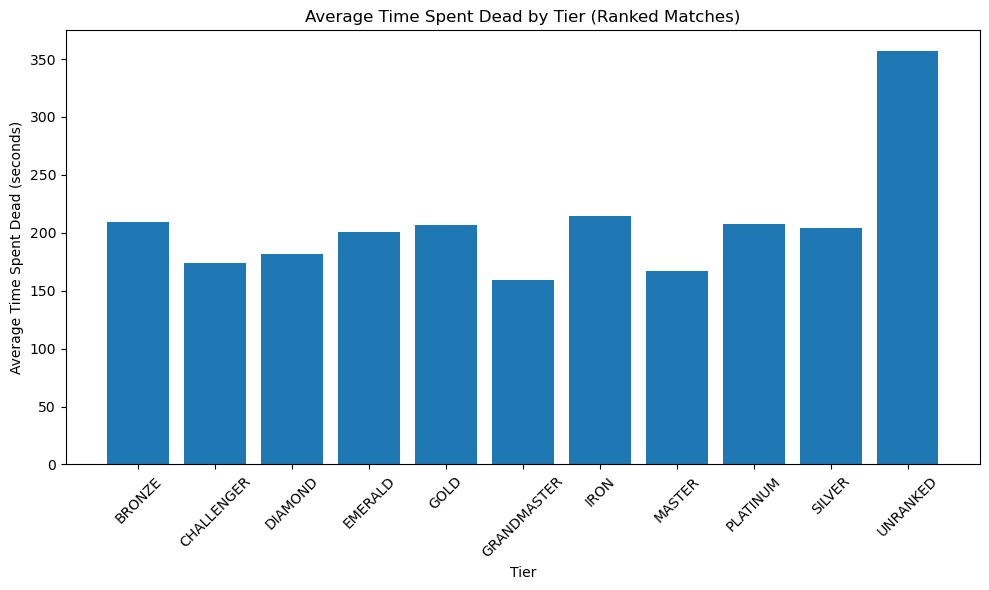

In [ ]:
avg_dead_ranked = rank_player_match_data["totalTimeSpentDead"].astype(float).mean()
print(f"Overall Average Time Spent Dead in Ranked: {avg_dead_ranked:.2f} seconds")

# Convert to numeric in case it's read as string
rank_player_match_data["totalTimeSpentDead"] = rank_player_match_data["totalTimeSpentDead"].astype(float)

# Group by tier and calculate the mean
avg_dead_by_tier = rank_player_match_data.groupby("tier")["totalTimeSpentDead"].mean().reset_index()

# Optional: enforce tier order (if tier is categorical like Iron, Bronze, etc.)
# If it's numeric, we just sort
avg_dead_by_tier = avg_dead_by_tier.sort_values("tier")


plt.figure(figsize=(10, 6))
plt.bar(avg_dead_by_tier["tier"].astype(str), avg_dead_by_tier["totalTimeSpentDead"])
plt.xlabel("Tier")
plt.ylabel("Average Time Spent Dead (seconds)")
plt.title("Average Time Spent Dead by Tier (Ranked Matches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Overall Average Deaths per Player in Swiftplay: 160.12


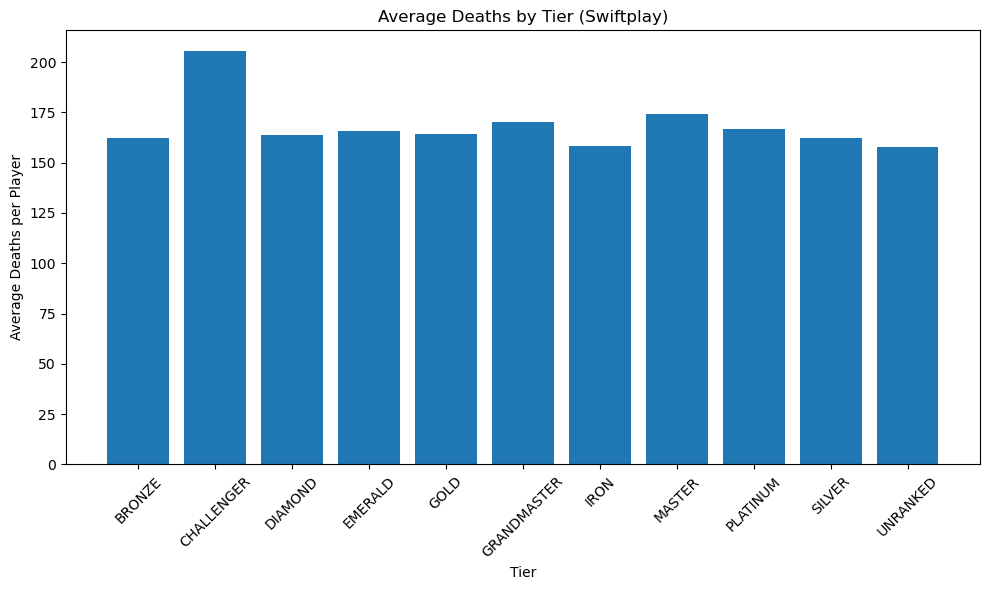

In [ ]:
swift_player_match_data["totalTimeSpentDead"] = swift_player_match_data["totalTimeSpentDead"].astype(float)

avg_deaths_swift = swift_player_match_data["totalTimeSpentDead"].mean()
print(f"Overall Average Deaths per Player in Swiftplay: {avg_deaths_swift:.2f}")

avg_deaths_by_tier_swift = swift_player_match_data.groupby("tier")["totalTimeSpentDead"].mean().reset_index()
avg_deaths_by_tier_swift = avg_deaths_by_tier_swift.sort_values("tier")

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(avg_deaths_by_tier_swift["tier"].astype(str), avg_deaths_by_tier_swift["totalTimeSpentDead"])
plt.xlabel("Tier")
plt.ylabel("Average Deaths per Player")
plt.title("Average Deaths by Tier (Swiftplay)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

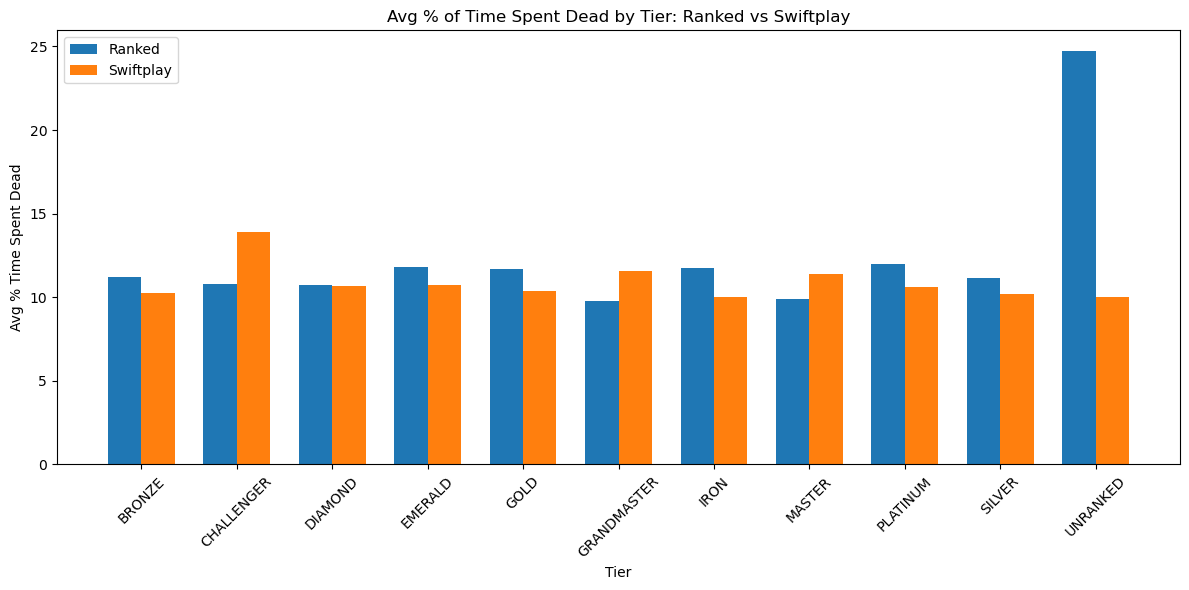

In [ ]:
# Convert columns to numeric
rank_player_match_data["totalTimeSpentDead"] = rank_player_match_data["totalTimeSpentDead"].astype(float)
rank_player_match_data["timePlayed"] = rank_player_match_data["timePlayed"].astype(float)

ranked_valid = rank_player_match_data[rank_player_match_data["timePlayed"] > 0].copy()

# Compute dead-time ratio per player
ranked_valid["dead_time_ratio"] = ranked_valid["totalTimeSpentDead"] / ranked_valid["timePlayed"]

# Group by tier
ranked_ratio_by_tier = ranked_valid.groupby("tier")["dead_time_ratio"].mean().reset_index()
ranked_ratio_by_tier = ranked_ratio_by_tier.sort_values("tier")

swift_player_match_data["totalTimeSpentDead"] = swift_player_match_data["totalTimeSpentDead"].astype(float)

# Merge with match data to get timePlayed (from match duration)
swift_merged = pd.merge(swift_player_match_data, swift_match_data[["matchId", "gameDuration"]], on="matchId")
swift_merged["gameDuration"] = swift_merged["gameDuration"].astype(float)

swift_valid = swift_merged[swift_merged["gameDuration"] > 0].copy()

swift_valid["dead_time_ratio"] = swift_valid["totalTimeSpentDead"] / swift_valid["timePlayed"]

# Group by tier
swift_ratio_by_tier = swift_valid.groupby("tier")["dead_time_ratio"].mean().reset_index()
swift_ratio_by_tier = swift_ratio_by_tier.sort_values("tier")
ranked_ratio_by_tier.rename(columns={"dead_time_ratio": "Ranked"}, inplace=True)
swift_ratio_by_tier.rename(columns={"dead_time_ratio": "Swiftplay"}, inplace=True)

# Merge both
comparison_ratio = pd.merge(ranked_ratio_by_tier, swift_ratio_by_tier, on="tier")


x = np.arange(len(comparison_ratio))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, comparison_ratio["Ranked"] * 100, width, label="Ranked")
plt.bar(x + width/2, comparison_ratio["Swiftplay"] * 100, width, label="Swiftplay")

plt.xlabel("Tier")
plt.ylabel("Avg % Time Spent Dead")
plt.title("Avg % of Time Spent Dead by Tier: Ranked vs Swiftplay")
plt.xticks(x, comparison_ratio["tier"].astype(str), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
print(rank_player_match_data.columns)
print(player_data.columns)
print(rank_match_data.columns)
print(swift_match_data.columns)
print(swift_player_match_data.columns)

Index(['matchId', 'puuid', 'teamId', 'summonerLevel', 'role', 'teamPosition',
       'kills', 'deaths', 'assists', 'championId', 'win',
       'teamEarlySurrendered', 'totalTimeSpentDead', 'timePlayed',
       'longestTimeSpentLiving', 'tier', 'rank', 'championLevel',
       'championPoints', 'full_rank'],
      dtype='object')
Index(['puuid', 'summonerLevel', 'tier', 'rank', 'swiftplay_kills',
       'swiftplay_deaths', 'swiftplay_assists', 'swiftplay_kd', 'swiftplay_ad',
       'swiftplay_kda', 'swiftplay_kad', 'swiftplay_win_loss_ratio',
       'ranked_kills', 'ranked_deaths', 'ranked_assists', 'ranked_kd',
       'ranked_ad', 'ranked_kda', 'ranked_kad', 'ranked_win_loss_ratio',
       'full_rank'],
      dtype='object')
Index(['matchId', 'gameDuration', 'endOfGameResult', 'gameEndedInSurrender',
       'gameEndedInEarlySurrender'],
      dtype='object')
Index(['matchId', 'gameDuration', 'endOfGameResult', 'gameEndedInSurrender',
       'gameEndedInEarlySurrender'],
      dtype='obj